In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import fnmatch
import cv2
import argparse
import pickle
import os
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import random

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4095255859727643816
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11036288259957190986
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Using TensorFlow backend.


In [2]:
# source: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/notebook
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True) # search pathname/folder to find .png files recursively then parse files
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


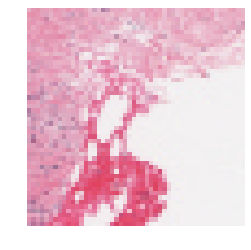

In [3]:
image_name = "IDC_regular_ps50_idx5/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

In [4]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero) #filename pattern matching returns subset of list of names
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']


In [5]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
%time
X,Y = proc_images(0,200000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

Wall time: 0 ns


In [7]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 200000
Number of IDC(-) Images: 139588
Number of IDC(+) Images: 60412
Percentage of positive images: 30.21%
Image shape (Width, Height, Channels): (50, 50, 3)


In [8]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


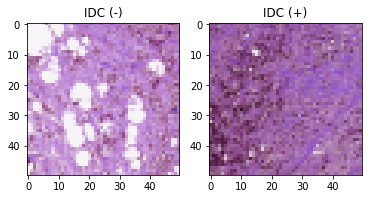

In [9]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 

In [10]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


In [12]:
#Source: (fashion MNIST) https://www.tensorflow.org/tutorials/keras/basic_classification
#Source: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/?fbclid=lwAR3WMQfZB513JosNLudYcv6DaaVwEv5pD6rQEMB4l_fDRxlwWfNG8gObmJU
#Source: https://www.keras.io/getting-started/sequential-model-guide/

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D
from keras.layers import Flatten, Activation
import keras.backend as K

model=Sequential()

#VGG-like convnet architecture
model.add(Conv2D(filters=32,kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(50,50,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

INIT_LR = 0.01
EPOCHS = 30

print("[INFO] training network...")
opt = SGD(lr=INIT_LR)

#Source: (fashion MNIST) https://www.tensorflow.org/tutorials/keras/basic_classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
                 metrics=['accuracy'])
# train the network
H = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=EPOCHS, batch_size=32)

model.summary()

[INFO] training network...
Train on 170000 samples, validate on 30000 samples
Epoch 1/30
170000/170000 [==============================] - 94s 551us/step - loss: 0.4854 - acc: 0.7793 - val_loss: 0.4136 - val_acc: 0.8213
Epoch 2/30
170000/170000 [==============================] - 64s 378us/step - loss: 0.4075 - acc: 0.8255 - val_loss: 0.4418 - val_acc: 0.8058
Epoch 3/30
170000/170000 [==============================] - 63s 370us/step - loss: 0.3841 - acc: 0.8369 - val_loss: 0.4720 - val_acc: 0.7811
Epoch 4/30
170000/170000 [==============================] - 62s 366us/step - loss: 0.3685 - acc: 0.8444 - val_loss: 0.3689 - val_acc: 0.8535
Epoch 5/30
170000/170000 [==============================] - 67s 393us/step - loss: 0.3567 - acc: 0.8489 - val_loss: 0.3664 - val_acc: 0.8433
Epoch 6/30
170000/170000 [==============================] - 69s 403us/step - loss: 0.3486 - acc: 0.8528 - val_loss: 0.3524 - val_acc: 0.8558
Epoch 7/30
170000/170000 [==============================] - 64s 374us/step -

[INFO] evaluating network...
30000/30000 [==============================] - 5s 159us/step


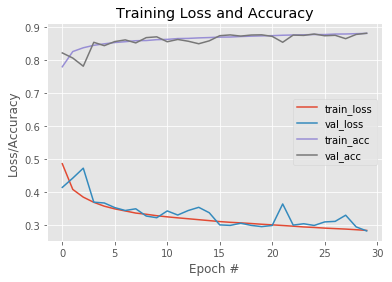

In [13]:
#Source: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/?fbclid=lwAR3WMQfZB513JosNLudYcv6DaaVwEv5pD6rQEMB4l_fDRxlwWfNG8gObmJU

# evaluate the network
print("[INFO] evaluating network...")
score = model.evaluate(X_test, Y_test, batch_size=32)


# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
